Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 13145 images belonging to 82 classes.
Found 3250 images belonging to 82 classes.
Model loaded successfully
Training history file not found
    Test Loss: 0.94045
Test Accuracy: 78.65%
102/102 [==============================] - 30s 291ms/step
The first 5 predictions: ['Akarna_Dhanurasana', 'Akarna_Dhanurasana', 'Akarna_Dhanurasana', 'Akarna_Dhanurasana', 'Akarna_Dhanurasana']

Classification Report:
                                                                           precision    recall  f1-score   support

  Pose_Dedicated_to_the_Sage_Koundinya_or_Eka_Pada_Koundinyanasana_I_and_II      0.61      0.83      0.70        24
          Upward_Facing_Two-Foot_Staff_Pose_or_Dwi_Pada_Viparita_Dandasana_      0.82      0.75      0.78        12
                                                                           accuracy                                                         accur

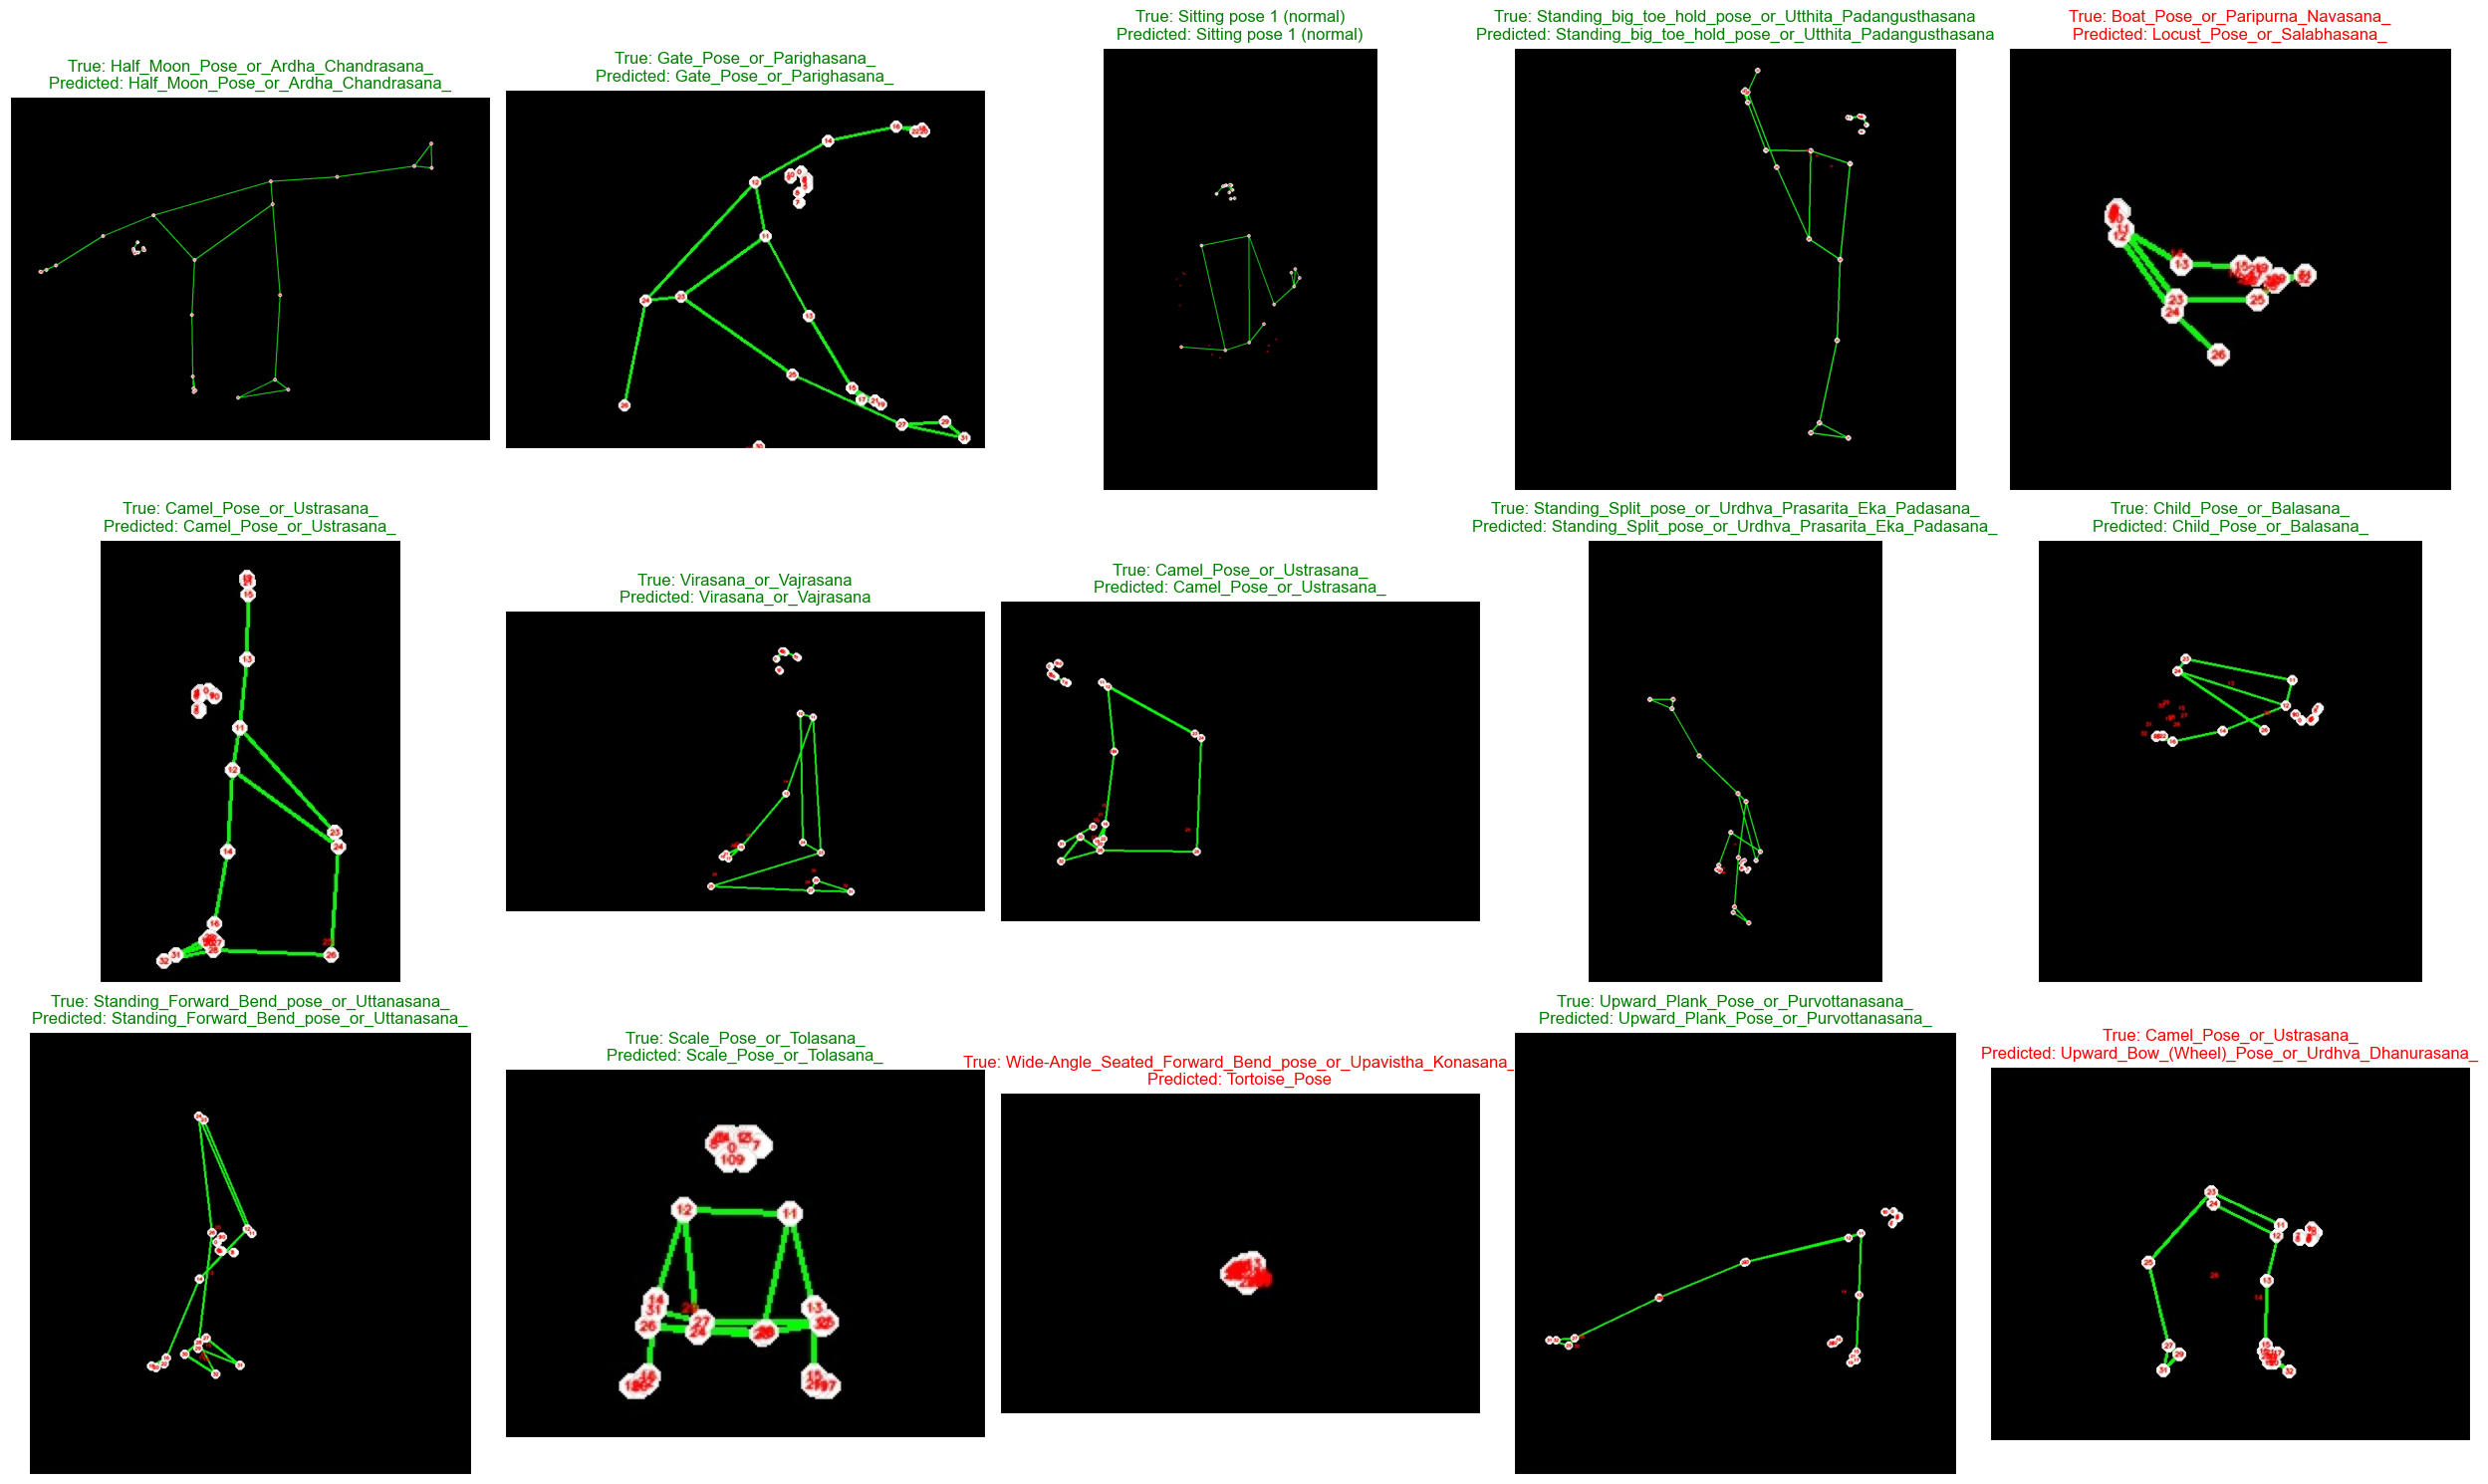

In [5]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image, ImageFile

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("No GPU detected, using CPU instead.")

# System libraries
from pathlib import Path
import os.path
import requests
import sys
import os

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Data loading and preprocessing
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

# Changed: Aligned data generator with training settings
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    rescale=1./255  # Changed: using same preprocessing as training
)

test_generator = ImageDataGenerator(
    rescale=1./255  # Changed: using same preprocessing as training
)

# Changed: Using directory-based data loading like in training
dataset_path = r'C:\Users\Anderson\Documents\GitHub\COMP9444_project\Dataset\Yoga-82\yoga_dataset_links_skeleton'  # Update with your path

# Changed: Removed DataFrame-based loading and using directory structure directly
train_ds = data_generator.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

val_ds = data_generator.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

def print_classification_report(report):
    # 打印头部
    print("\nClassification Report:")
    print(" " * 75 + "precision    recall  f1-score   support")
    print()
    
    # 按行处理报告
    for line in report.split('\n'):
        if not line.strip():  # 跳过空行
            continue
            
        if line.lstrip().startswith('accuracy'):
            name = 'accuracy'
            line = line[8:]  # 移除 "accuracy"
            print(" " * 75 + name + line)
        elif line.lstrip().startswith('macro'):
            name = 'macro avg'
            line = line[21:]  # 移除 "macro avg"
            print(" " * 75 + name + line)
        elif line.lstrip().startswith('weighted'):
            name = 'weighted avg'
            line = line[21:]  # 移除 "weighted avg"
            print(" " * 75 + name + line)
        elif not line.startswith(' ' * 10):  # 跳过原始表头行
            try:
                # 处理常规类别行
                items = line.split()
                if len(items) >= 5:  # 确保行有足够的元素
                    metrics = items[-4:]  # 最后4个元素是指标
                    name = " ".join(items[:-4])  # 其余的是类名
                    metrics_str = "{:>9} {:>9} {:>9} {:>9}".format(*metrics)
                    print(f"{name:>75} {metrics_str}")
            except Exception as e:
                continue  # 如果有任何处理错误，跳过该行

# Load model
model = tf.keras.models.load_model("yoga_pose_model_final.h5")  # Update with your model path
print("Model loaded successfully")

# 在加载模型后添加以下代码
def plot_training_curves():
    # Loss曲线
    plt.figure(figsize=(8, 6))
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Accuracy曲线
    plt.figure(figsize=(8, 6))
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 加载训练历史
try:
    history = np.load('training_history.npy', allow_pickle=True).item()
    plot_training_curves()
except:
    print("Training history file not found")

# Evaluate model
results = model.evaluate(val_ds, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# Predict
predictions = model.predict(val_ds)
pred_indices = np.argmax(predictions, axis=1)

# Get class names directly from directory structure to maintain same order
class_names = sorted(os.listdir(dataset_path))  # Changed: Getting classes in same order as training
pred = [class_names[idx] for idx in pred_indices]

print(f'The first 5 predictions: {pred[:5]}')

# Get true labels
true_labels = []
filenames = val_ds.filenames
for filename in filenames:
    class_name = os.path.split(os.path.dirname(filename))[1]
    true_labels.append(class_name)

# Generate classification report with proper formatting
report = classification_report(true_labels, pred)
print_classification_report(report)

# Display Results
# Changed: Using directory structure to get images
image_files = [os.path.join(dataset_path, true_labels[i], os.path.basename(filenames[i])) 
               for i in range(len(filenames))]
random_indices = np.random.randint(0, len(image_files), 15)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = image_files[random_indices[i]]
    ax.imshow(plt.imread(img_path))
    color = "green" if true_labels[random_indices[i]] == pred[random_indices[i]] else "red"
    ax.set_title(f"True: {true_labels[random_indices[i]]}\nPredicted: {pred[random_indices[i]]}", 
                color=color)

plt.tight_layout()
plt.show()

# Save important metrics
results_df = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy'],
    'Value': [results[0], results[1]]
})
results_df.to_csv('evaluation_results.csv', index=False)